<div style="text-align:center;">
    <img style="width: 30%;" src="static/imgs/Logo_course.png">
    <p style="margin-top:10px;">paul.andres.munoz@gmail.com<br>paul.munoz@vub.be</p>
</div>
    

# Part 3: Development of hydrological forecasting models

In this session, we will:
   - Develop forecasting models for the mountain catchment

## Import Libraries

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as dates
import os
import datetime
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from copy import deepcopy
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import itertools
import random

def lagged_dataset(arr, num_steps, additional_arr, new_num_steps):
    num_columns = arr.shape[1]
    modified_rows = []
    excluded_data = []
    for i in range(num_steps, arr.shape[0]):
        prev_rows = arr[i - num_steps:i]
        current_row = arr[i]
        new_row = np.concatenate((prev_rows.flatten(), current_row))
        modified_rows.append(new_row)
    result_array = np.array(modified_rows)
    # Slicing the result_array to match the number of rows in modified_additional_arr
    if result_array.shape[0] > additional_arr.shape[0]:
        result_array = result_array[result_array.shape[0] - additional_arr.shape[0]:]

    modified_rows = []
    for i in range(new_num_steps, additional_arr.shape[0]):
        prev_rows = additional_arr[i - new_num_steps:i]
        current_row = additional_arr[i]
        excluded_data.append(current_row[-1])  # Store excluded data
        new_row = np.concatenate((prev_rows.flatten(), current_row[:-1]))  # Exclude last column
        modified_rows.append(new_row)

    modified_additional_arr = np.array(modified_rows)

    # Adjust dimensions by removing rows from result_array or modified_additional_arr
    min_rows = min(result_array.shape[0], modified_additional_arr.shape[0])
    result_array = result_array[-min_rows:]
    modified_additional_arr = modified_additional_arr[-min_rows:]
    excluded_data = np.array(excluded_data)[-min_rows:]

    # Concatenate result_array and modified_additional_arr
    final_result = np.concatenate((result_array, modified_additional_arr), axis=1)

    return final_result, np.array(excluded_data)[:, None]

def lagged_dataset_pron(arr, num_steps, additional_arr, new_num_steps, lead_time):
    num_columns = arr.shape[1]
    modified_rows = []
    excluded_data = []

    for i in range(num_steps, arr.shape[0]):
        prev_rows = arr[i - num_steps:i]
        current_row = arr[i]
        new_row = np.concatenate((prev_rows.flatten(), current_row))
        modified_rows.append(new_row)

    result_array = np.array(modified_rows)

    # Slicing the result_array to match the number of rows in modified_additional_arr
    if result_array.shape[0] > additional_arr.shape[0]:
        result_array = result_array[result_array.shape[0] - additional_arr.shape[0]:]

    modified_rows = []
    for i in range(new_num_steps, additional_arr.shape[0]):
        prev_rows = additional_arr[i - new_num_steps:i]
        current_row = additional_arr[i]
        excluded_data.append(current_row[-1])  # Store excluded data
        new_row = np.concatenate((prev_rows.flatten(), current_row))  # Include last column
        modified_rows.append(new_row)

    modified_additional_arr = np.array(modified_rows)

    # Adjust dimensions by removing rows from result_array or modified_additional_arr
    min_rows = min(result_array.shape[0], modified_additional_arr.shape[0])
    result_array = result_array[-min_rows:]
    modified_additional_arr = modified_additional_arr[-min_rows:]
    excluded_data = np.array(excluded_data)[-min_rows:]

    # Shift excluded_data by lead_time
    excluded_data = excluded_data[lead_time:]

    # Concatenate result_array and modified_additional_arr
    final_result = np.concatenate((result_array, modified_additional_arr), axis=1)

    # Resize final_result and excluded_data to have the same number of rows
    min_rows = min(final_result.shape[0], excluded_data.shape[0])
    final_result = final_result[:min_rows]
    excluded_data = excluded_data[:min_rows]

    return final_result, np.array(excluded_data)[:, None]


def calculate_hydro_metrics(simulations, evaluation):
    sim_mean = np.mean(simulations, axis=0, dtype=np.float64)
    obs_mean = np.mean(evaluation, dtype=np.float64)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0, dtype=np.float64)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0, dtype=np.float64)
                    * np.sum((evaluation - obs_mean) ** 2,
                             dtype=np.float64))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation, dtype=np.float64)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0, dtype=np.float64)
            / np.sum(evaluation, dtype=np.float64))
    # calculate the Kling-Gupta Efficiency KGE
    kge = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    rmse = np.sqrt(np.mean((evaluation - simulations) ** 2,
                            axis=0, dtype=np.float64))
    pbias = (100 * np.sum(evaluation - simulations, axis=0, dtype=np.float64)
              / np.sum(evaluation))
    r2 = 1 - (np.sum((evaluation - simulations)**2) / np.sum((evaluation - np.mean(evaluation))**2))
    return kge, rmse, pbias, r2
np.random.seed(22)
random.seed(22)

## Select project folder

In [2]:
folder = os.getcwd()+'/data/'
folder

'/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/'

## Import precipitation data

### Satellite precipitation

Read data from the mountain catchment

In [7]:
# Import satellite precipitation data
precipitation_satellite = pd.read_table(folder + 'PERSIANN-CCS_UTC_daily_catchment_1.csv', sep=',')
# Rename columns
precipitation_satellite.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
# Convert the 'Date' column to datetime format
precipitation_satellite['Date'] = precipitation_satellite['Date'].apply(lambda x: pd.to_datetime(x, dayfirst=True))
# Set 'Date' as the index
precipitation_satellite.set_index(precipitation_satellite['Date'], inplace=True)
# Drop the redundant 'Date' column (updated for future pandas versions)
precipitation_satellite = precipitation_satellite.drop(labels='Date', axis=1)

In [8]:
precipitation_satellite

,1,2,3,6,7,8,9,10,12,13,...,21,22,23,24,25,26,27,28,31,32
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-01-02,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-01-03,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-01-04,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-01-05,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-09,0.0,0.2,0.48,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,1.2,0.0,0.0,1.41,0.5,0.0,1.22,5.22,2.12,0.5
2023-08-10,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2023-08-11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0


Calculate annual precipitation

In [9]:
data_annual = precipitation_satellite.resample('Y',label='right',closed='right').sum()

Plot average annual precipitation.

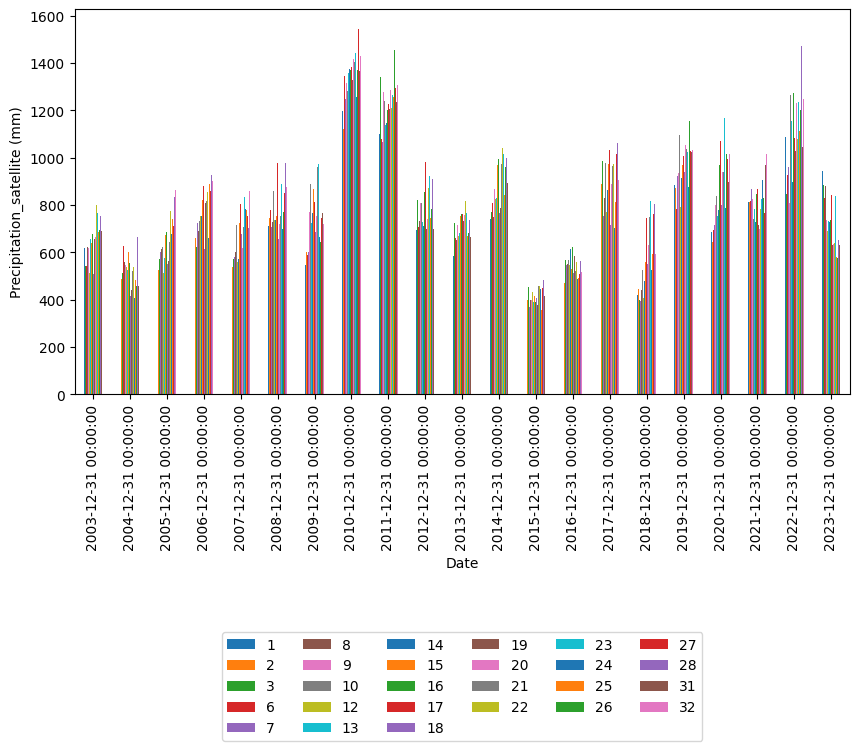

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_annual.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Calculate average annual precipitation for all pixels in the basin.

In [12]:
data_annual_average =  data_annual.mean(axis=1)
data_annual_average

Date
2003-12-31     646.573704
2004-12-31     518.426667
2005-12-31     647.289630
2006-12-31     785.916296
2007-12-31     688.204074
2008-12-31     783.095185
2009-12-31     757.777407
2010-12-31    1350.764074
2011-12-31    1214.637037
2012-12-31     774.968518
2013-12-31     703.155185
2014-12-31     867.641481
2015-12-31     411.308889
2016-12-31     546.482593
2017-12-31     896.134815
2018-12-31     575.480741
2019-12-31     961.138519
2020-12-31     856.483704
2021-12-31     816.882222
2022-12-31    1086.663333
2023-12-31     725.140741
Freq: A-DEC, dtype: float64

Plot the average precipitation (all pixels).

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_annual_average.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Calculate the average annual precipitation in the basin.

In [13]:
data_annual_average.mean()

791.1507054652681

Calculate monthly precipitation.

In [14]:
data_monthly = precipitation_satellite.resample('M',label='right',closed='right').sum() 
data_monthly

,1,2,3,6,7,8,9,10,12,13,...,21,22,23,24,25,26,27,28,31,32
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-31,18.53,23.37,29.94,22.73,39.06,42.16,40.16,39.92,29.47,40.56,...,45.47,53.39,56.34,33.75,41.68,56.50,51.82,43.20,48.60,52.30
2003-02-28,75.35,76.53,40.15,41.76,50.23,51.24,51.58,51.47,39.63,40.90,...,55.21,46.67,38.47,29.85,33.75,36.01,54.97,42.35,41.17,49.25
2003-03-31,33.84,33.78,61.99,33.31,32.94,43.43,47.93,47.92,35.19,38.17,...,127.65,113.41,85.31,39.25,58.83,69.97,100.33,111.59,65.35,85.21
2003-04-30,67.83,39.61,36.54,116.87,111.30,71.06,55.90,97.56,57.83,77.65,...,96.13,138.09,81.70,70.13,94.21,92.85,60.37,117.50,90.72,143.74
2003-05-31,1.64,1.03,1.03,1.46,2.47,3.91,3.65,1.57,3.52,5.11,...,1.94,2.21,33.88,0.00,1.18,1.96,2.32,7.70,1.22,2.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,282.20,300.62,318.64,317.19,328.45,308.91,289.28,270.67,312.74,321.06,...,272.43,255.13,300.12,279.92,244.27,247.67,285.49,250.60,245.79,238.41
2023-05-31,142.07,110.56,74.78,81.62,63.36,58.01,59.44,68.27,83.39,50.48,...,56.28,57.32,96.61,35.55,47.45,43.04,43.20,41.47,44.51,54.98
2023-06-30,13.84,8.62,7.92,7.50,8.57,13.41,7.89,7.35,5.23,5.58,...,4.95,9.65,3.56,4.03,2.21,4.31,9.20,5.95,6.88,21.07


Calculate monthly precipitation.

In [15]:
data_monthly_mean_pixels =  data_monthly.mean(axis=1)
data_monthly_mean_pixels

Date
2003-01-31     40.502593
2003-02-28     45.911111
2003-03-31     60.481111
2003-04-30     84.432963
2003-05-31      3.860370
                 ...    
2023-04-30    283.854074
2023-05-31     64.770370
2023-06-30      7.100000
2023-07-31     13.341111
2023-08-31      0.501852
Freq: M, Length: 248, dtype: float64

Plot

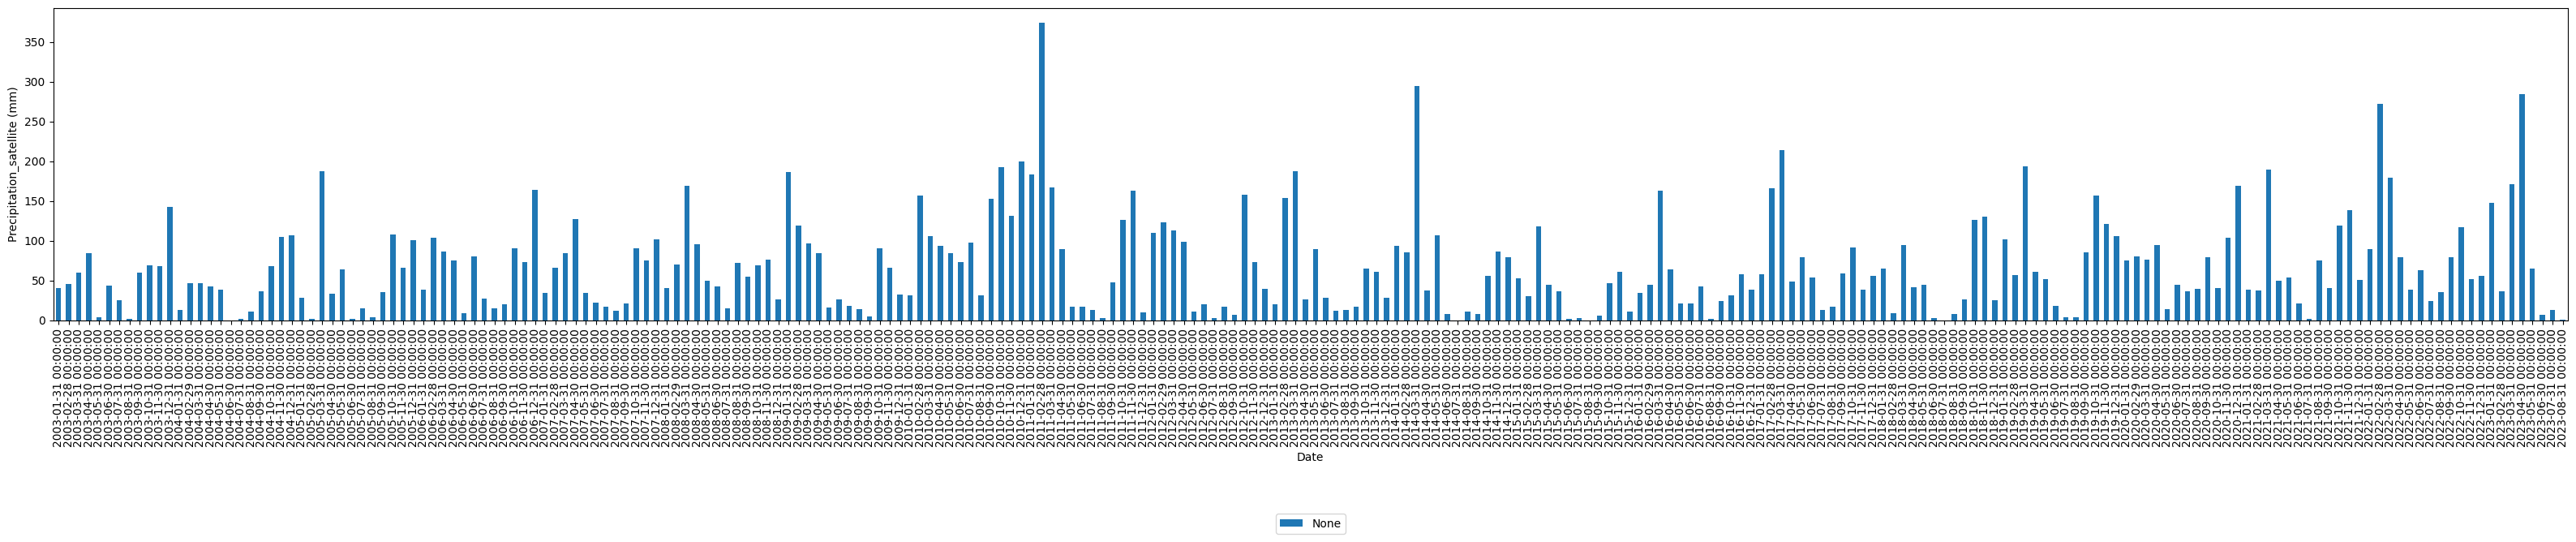

In [16]:
fig, ax = plt.subplots(figsize=(40,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_monthly_mean_pixels.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Calculate average monthly precipitation (average of all pixels in the basin).

In [17]:
data_monthly_mean= data_monthly_mean_pixels.groupby(data_monthly_mean_pixels.index.month).mean()
data_monthly_mean

Date
1      70.852099
2      99.124885
3     142.750617
4      78.946543
5      44.431270
6      28.550265
7      18.388448
8      18.638889
9      43.499741
10     95.832000
11     87.352870
12     77.256463
dtype: float64

Plot

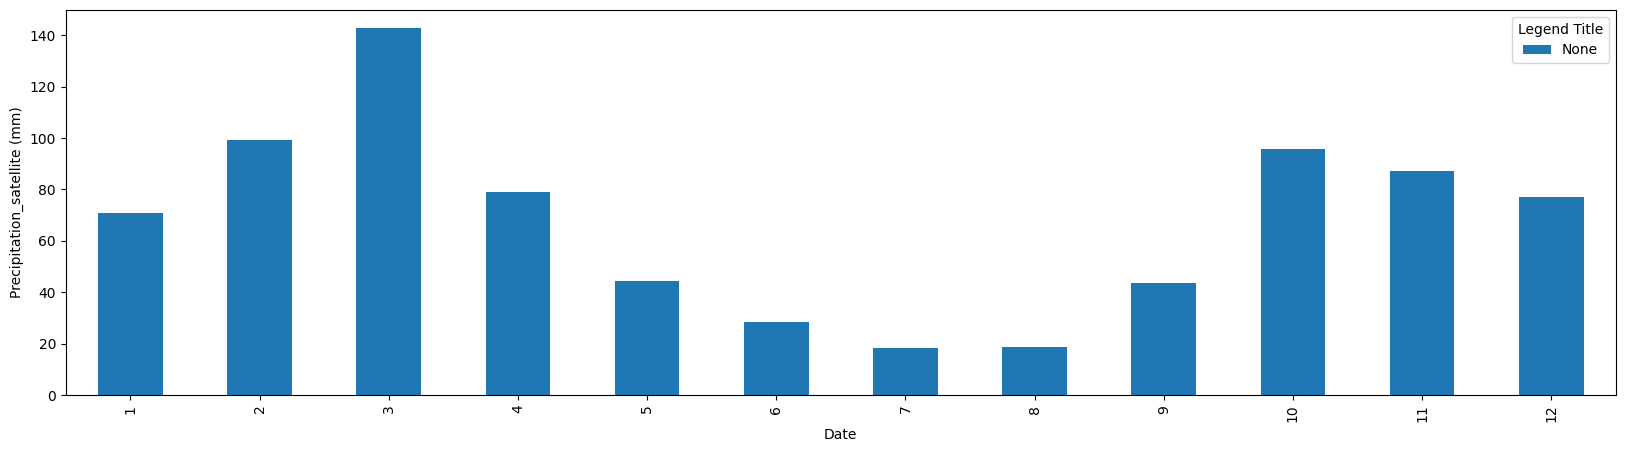

In [18]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_monthly_mean.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
plt.show()

### Import in-situ precipitation

Let's use three rain gauges installed within the catchment.

#### For rain gauge 1
Import and preprocess the data.

In [39]:
folder_pcp_1 = folder+'Rain_gauge_1/'
df_pcp_1= pd.read_table(folder_pcp_1+'Rain_gauge_1.csv', sep=',')
df_pcp_1.rename(columns={'Texas_tip_corrected_mm':'Pluviómetro_1'},inplace=True)
df_pcp_1.columns
df_pcp_1

,Date_yy/mm/dd_hh:mm:ss,Pluviómetro_1
0,2012-10-02 12:00:00,NaN
1,2012-10-02 13:00:00,0.0
2,2012-10-02 14:00:00,0.0
3,2012-10-02 15:00:00,0.0
4,2012-10-02 16:00:00,0.0
...,...,...
95638,2023-08-31 10:00:00,0.0
95639,2023-08-31 11:00:00,0.0
95640,2023-08-31 12:00:00,0.0
95641,2023-08-31 13:00:00,0.0


Operations to organize the information into a manageable dataframe.

In [40]:
# Rename the column 'Date_yy/mm/dd_hh:mm:ss' to 'Date'
df_pcp_1.rename(columns={'Date_yy/mm/dd_hh:mm:ss': 'Date'}, inplace=True)
# Convert the 'Date' column to datetime format
df_pcp_1['Date'] = df_pcp_1['Date'].apply(lambda x: pd.to_datetime(x, dayfirst=True))
# Set the 'Date' column as the index
df_pcp_1.set_index('Date', inplace=True)
df_pcp_1

,Pluviómetro_1
Date,
2012-10-02 12:00:00,NaN
2012-10-02 13:00:00,0.0
2012-10-02 14:00:00,0.0
2012-10-02 15:00:00,0.0
2012-10-02 16:00:00,0.0
...,...
2023-08-31 10:00:00,0.0
2023-08-31 11:00:00,0.0
2023-08-31 12:00:00,0.0


Plot the year 2020 from the imported precipitation series.

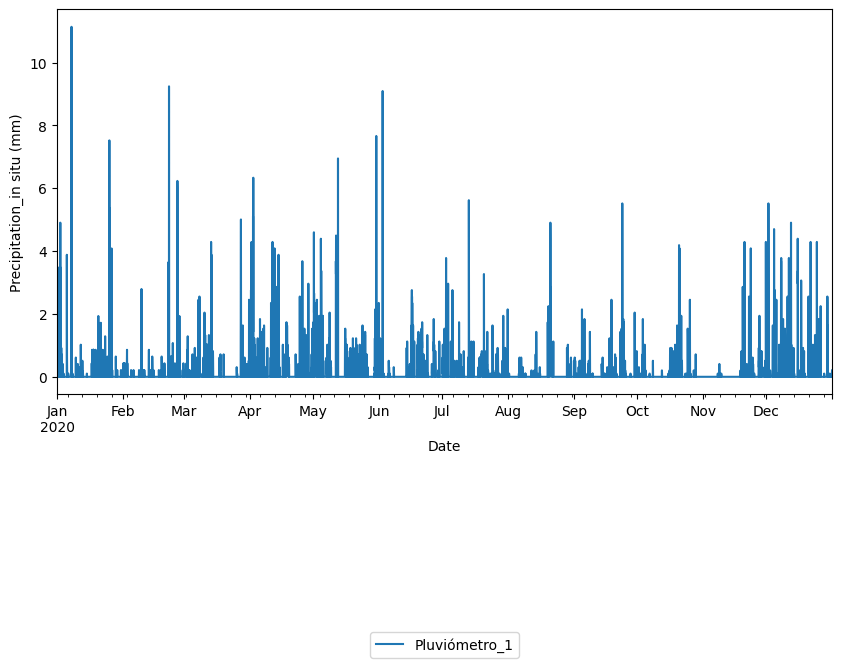

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_1.loc['2020'].plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Plot the accumulated precipitation for 2020 from the imported time series.

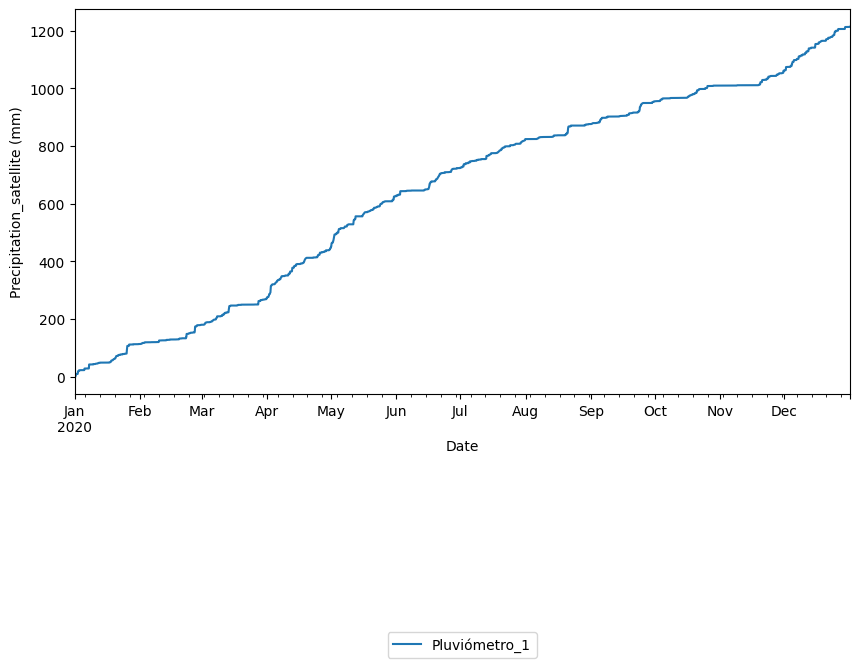

In [46]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_1.loc['2020'].cumsum().plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

#### For Rain Gauge 2

Import and preprocess the data.

In [61]:
folder_pcp_2 = folder+'Rain_gauge_2/'
df_pcp_2= pd.read_table(folder_pcp_2+'Rain_gauge_2.csv', sep=',')
df_pcp_2

,Date,Precipitation
0,2013-03-07 17:00:00,0.000000
1,2013-03-07 18:00:00,0.000000
2,2013-03-07 19:00:00,0.000000
3,2013-03-07 20:00:00,0.000000
4,2013-03-07 21:00:00,0.000000
...,...,...
94125,2023-12-02 14:00:00,0.000000
94126,2023-12-02 15:00:00,0.000000
94127,2023-12-02 16:00:00,0.000000
94128,2023-12-02 17:00:00,0.000000


Operaciones para crear un dataframe manejable

In [62]:
df_pcp_2['Date'] = df_pcp_2.Date.apply(lambda x: pd.to_datetime(x,dayfirst=True))
df_pcp_2.set_index(df_pcp_2['Date'],inplace=True)
df_pcp_2.rename(columns={'Precipitation':'Pluviómetro_2'},inplace=True)
df_pcp_2 = df_pcp_2.drop(labels='Date', axis=1)
df_pcp_2

,Pluviómetro_2
Date,
2013-03-07 17:00:00,0.000000
2013-03-07 18:00:00,0.000000
2013-03-07 19:00:00,0.000000
2013-03-07 20:00:00,0.000000
2013-03-07 21:00:00,0.000000
...,...
2023-12-02 14:00:00,0.000000
2023-12-02 15:00:00,0.000000
2023-12-02 16:00:00,0.000000


Plot the year 2020 from the imported series.

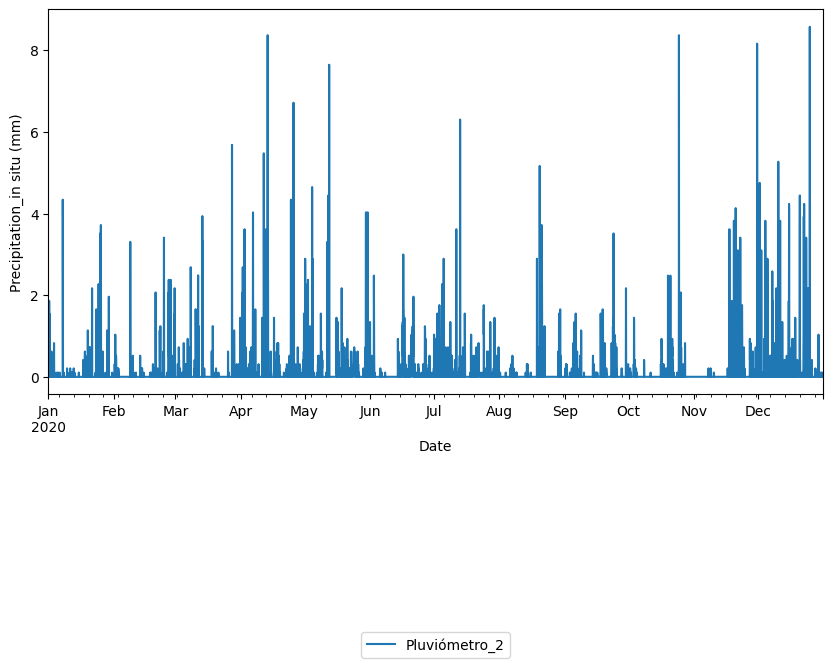

In [64]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_2.loc['2020'].plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Plot the accumulated precipitation for the year 2020 from the imported series.

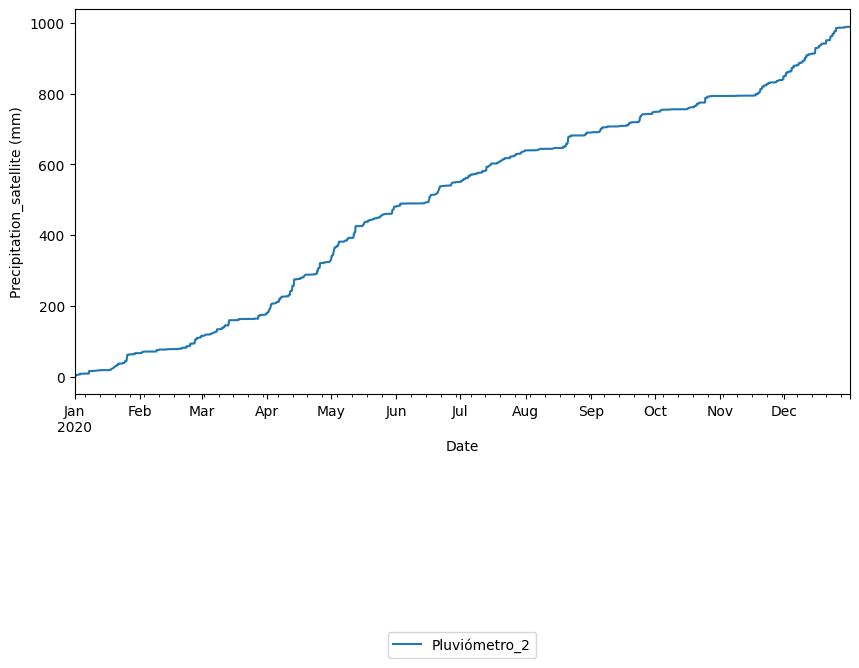

In [67]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_2.loc['2020'].cumsum().plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

#### For rain gauge 3

Import and preprocess the data.

In [74]:
folder_pcp_3 = folder+'Rain_gauge_3/'
df_pcp_3= pd.read_table(folder_pcp_3+'Rain_gauge_3.csv', sep=',')
df_pcp_3

,Fecha,Precipitation
0,2012-09-27 12:00:00,0.108980
1,2012-09-27 13:00:00,4.904100
2,2012-09-27 14:00:00,2.724500
3,2012-09-27 15:00:00,2.179600
4,2012-09-27 16:00:00,0.544900
...,...,...
97994,2023-12-02 14:00:00,0.000000
97995,2023-12-02 15:00:00,0.245533
97996,2023-12-02 16:00:00,0.000000
97997,2023-12-02 17:00:00,0.000000


Operations to create a manageable dataframe.

In [75]:
df_pcp_3['Fecha'] = df_pcp_3.Fecha.apply(lambda x: pd.to_datetime(x,dayfirst=True))
df_pcp_3.set_index(df_pcp_3['Fecha'],inplace=True)
df_pcp_3 = df_pcp_3.drop(labels='Fecha', axis=1)
df_pcp_3.rename(columns={'Precipitation':'Pluviómetro_3'},inplace=True)
df_pcp_3

,Pluviómetro_3
Fecha,
2012-09-27 12:00:00,0.108980
2012-09-27 13:00:00,4.904100
2012-09-27 14:00:00,2.724500
2012-09-27 15:00:00,2.179600
2012-09-27 16:00:00,0.544900
...,...
2023-12-02 14:00:00,0.000000
2023-12-02 15:00:00,0.245533
2023-12-02 16:00:00,0.000000


Plot the precipitation for the year 2020.

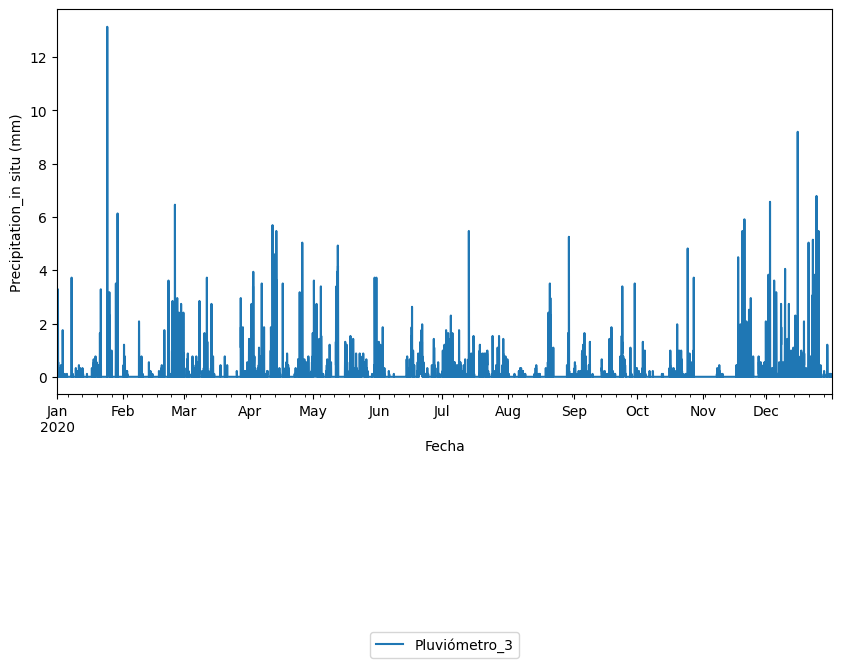

In [76]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_3.loc['2020'].plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Plot the accumulated precipitation for the year 2020.

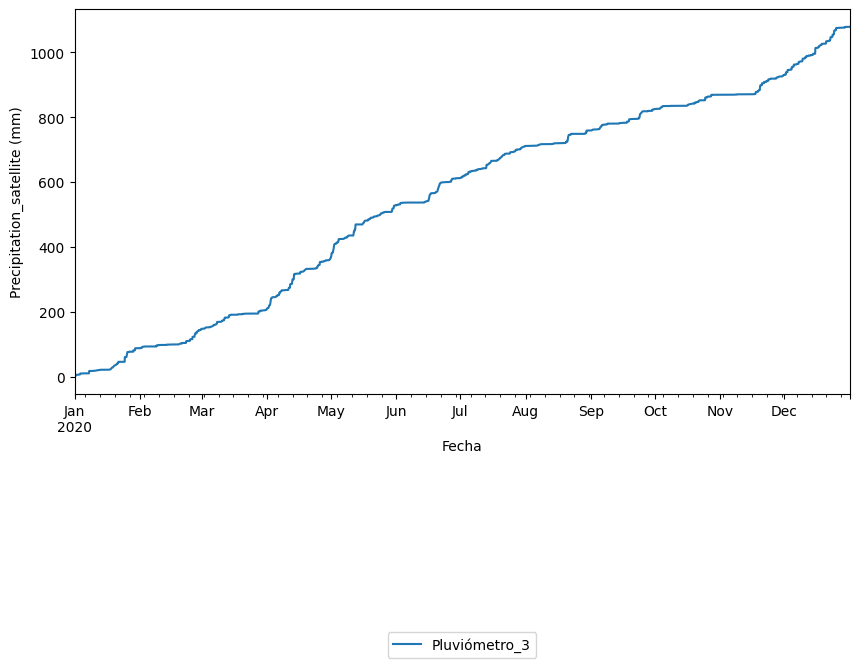

In [78]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_3.loc['2020'].cumsum().plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

#### Compare the in-situ precipitation

Resample the data from the 3 rain gauges to monthly scales.

In [79]:
df_pcp_1_monthly = df_pcp_1.resample('M',label='right',closed='right').sum() 
df_pcp_1_monthly= df_pcp_1_monthly.groupby(df_pcp_1_monthly.index.month).mean()
df_pcp_2_monthly = df_pcp_2.resample('M',label='right',closed='right').sum() 
df_pcp_2_monthly= df_pcp_2_monthly.groupby(df_pcp_2_monthly.index.month).mean()
df_pcp_3_monthly = df_pcp_3.resample('M',label='right',closed='right').sum() 
df_pcp_3_monthly= df_pcp_3_monthly.groupby(df_pcp_3_monthly.index.month).mean()
all_pcp_monthly = pd.concat([df_pcp_1_monthly, df_pcp_2_monthly, df_pcp_3_monthly], axis=1)

Plot

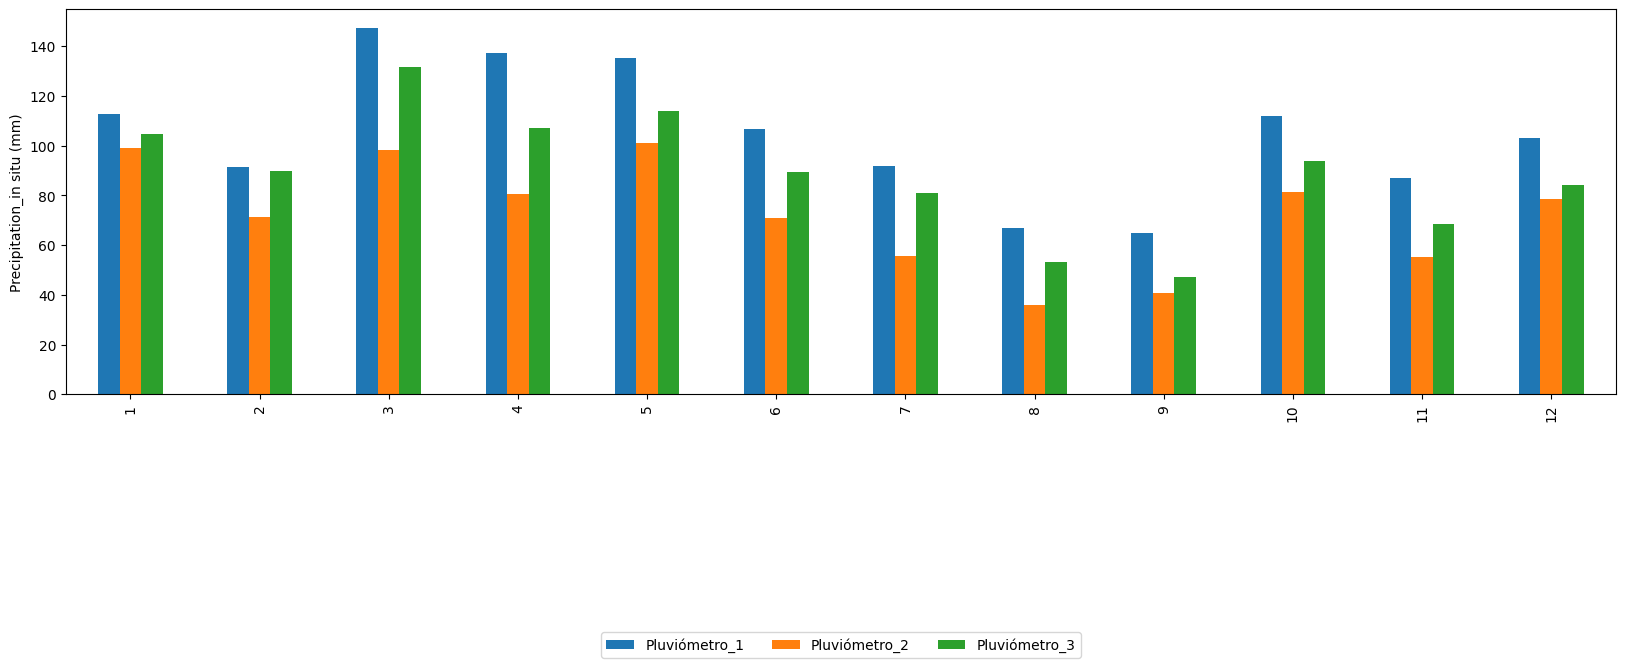

In [80]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
all_pcp_monthly.plot(kind='bar',ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

## Import runoff data

Import and organize runoff data into a manageable dataframe

In [85]:
folder_runoff = folder+'Runoff_catchment_1/'
df_runoff =  pd.read_excel(folder_runoff+'Runoff_catchment_1.xlsx')
df_runoff['Fecha'] = df_runoff.Fecha.apply(lambda x: pd.to_datetime(x,dayfirst=True))
df_runoff.set_index(df_runoff['Fecha'],inplace=True)
df_runoff = df_runoff.drop(labels='Fecha', axis=1)
df_runoff

,Caudal (m3/s)
Fecha,
1997-07-17 20:00:00,5.756145
1997-07-17 21:00:00,5.756145
1997-07-17 22:00:00,5.756145
1997-07-17 23:00:00,5.977188
1997-07-18 00:00:00,5.756145
...,...
2021-07-05 06:59:00,0.738076
2021-07-05 07:59:00,0.738934
2021-07-05 08:59:00,0.736365


Plot

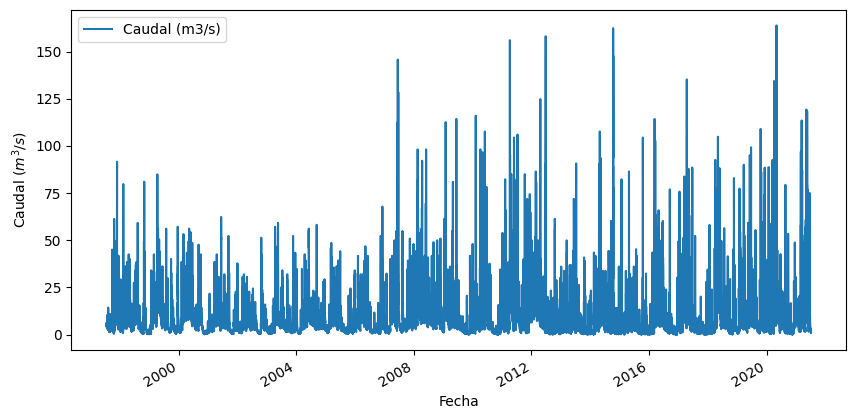

In [87]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_runoff.plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Caudal ($m^3/s$)')
# Adjusting the position of the legend
plt.legend()
plt.show()


## Unir los datos de precipitación (pluviómetros+satelitales) y caudal de la cuenca

In [89]:
df_pcp_1_daily = df_pcp_1.resample('D',label='right',closed='right').sum() 
df_pcp_2_daily = df_pcp_2.resample('D',label='right',closed='right').sum() 
df_pcp_3_daily = df_pcp_3.resample('D',label='right',closed='right').sum() 
df_runoff_daily = df_runoff.resample('D',label='right',closed='right').mean() 
all_data_daily = pd.concat([df_pcp_1_daily, df_pcp_2_daily, df_pcp_3_daily, precipitation_satellite, df_caudal_daily], axis=1)
all_data_daily

,Pluviómetro_1,Pluviómetro_2,Pluviómetro_3,1,2,3,6,7,8,9,...,22,23,24,25,26,27,28,31,32,Caudal (m3/s)
1997-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.800354
1997-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.510110
1997-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.573900
1997-07-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.166181
1997-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.233679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-30,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-02,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Determinar periodos con datos concurrentes

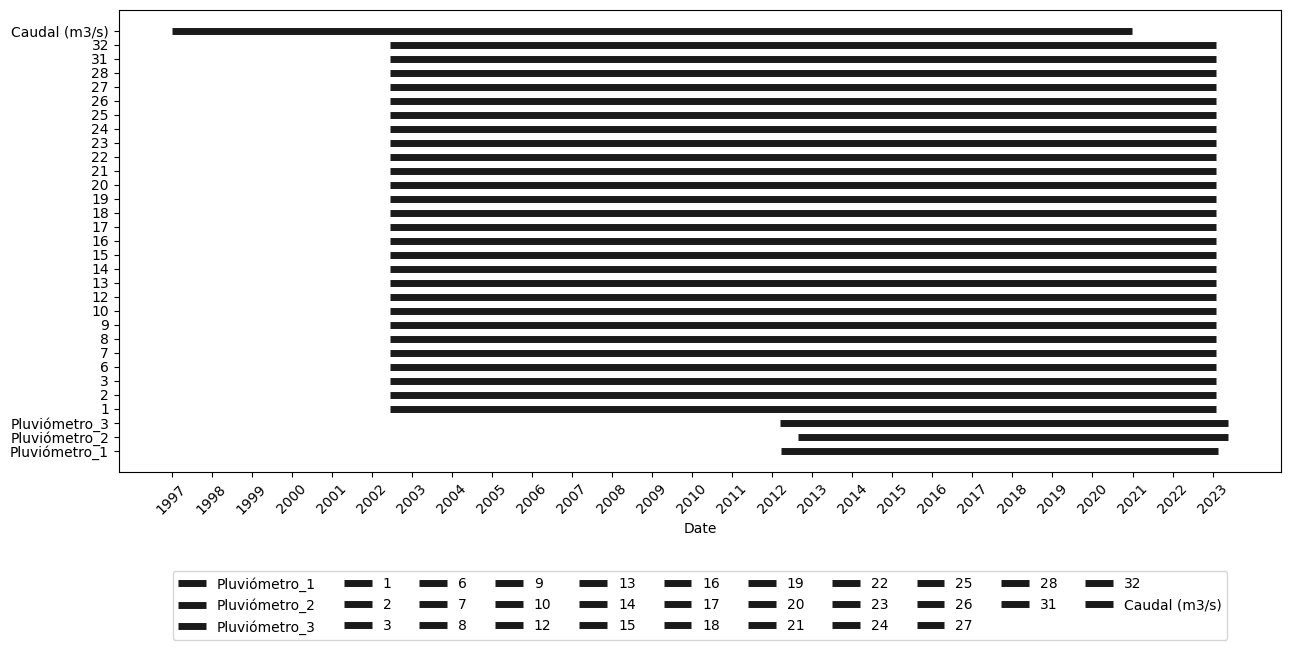

In [90]:
concurrent_periods = all_data_daily.dropna().index

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Loop through columns
for i, col in enumerate(all_data_daily.columns):
    # Get a boolean mask where data is not NaN for the current column
    mask = ~all_data_daily[col].isna()
    
    # Get the indices of True values in the mask
    indices = np.where(mask)[0]
    
    # Plot horizontal lines for continuity
    ax.hlines(i, indices[0], indices[-1], colors='0.1', linewidth=5, label=col)

# Set y-ticks and labels
ax.set_yticks(range(len(all_data_daily.columns)))
ax.set_yticklabels(all_data_daily.columns)

# Set x-axis label
ax.set_xlabel('Date')

# Set the x-axis ticks to show years
years = pd.to_datetime(all_data_daily.index).year
unique_years = np.unique(years)
ax.set_xticks(np.arange(len(all_data_daily.index), step=365))
ax.set_xticklabels(unique_years,rotation=45)

# Add legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=11)

# Show the plot
plt.show()


## Dividir datos en periodos de entrenamiento y prueba

In [ ]:
all_data_daily = all_data_daily[~(all_data_daily.isna().any(axis=1) | (all_data_daily.lt(0).any(axis=1)))]
input_data_train = np.array(all_data_daily['2013':'2019'].iloc[:,:-1])
input_data_test = np.array(all_data_daily['2020':'2021-06'].iloc[:,:-1])

In [ ]:
input_data_train

In [ ]:
output_data_train = np.reshape(np.array(all_data_daily['2013':'2019'].iloc[:,-1]),(all_data_daily['2013':'2019'].shape[0],1))
output_data_test = np.reshape(np.array(all_data_daily['2020':'2021-06'].iloc[:,-1]),(all_data_daily['2020':'2021-06'].shape[0],1))

In [ ]:
output_data_train

In [ ]:
input_data_train_lags, output_data_train_lags= lagged_dataset(input_data_train, 3, output_data_train,15)

In [ ]:
input_data_train_lags

In [ ]:
output_data_train_lags

In [ ]:
input_data_test_lags, output_data_test_lags= lagged_dataset(input_data_test, 3, output_data_test,15)

In [ ]:
input_data_test_lags

In [ ]:
output_data_test_lags

## Creación y entrenamiento de un modelo de Random Forest (no pronóstico)

### Definir hiperparámetros del modelo

In [ ]:
min_samples_splt=10
min_samples_lf=4
max_dpth=350
n_trees=600
max_ft='sqrt'                                             

### Definir el modelo

In [ ]:
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=22)

### Entrenar el modelo

In [ ]:
regr=regr.fit(input_data_train_lags, output_data_train_lags)


### Generar simulaciones para el periodo de entrenamiento

In [ ]:
simulations_data_train= regr.predict(input_data_train_lags)
simulations_data_train= np.reshape(simulations_data_train, (-1, 1))
simulations_data_train

### Generar simulaciones para el periodo de prueba


In [ ]:
#Prediction on unseen data
simulations_data_test= regr.predict(input_data_test_lags)
simulations_data_test= np.reshape(simulations_data_test, (-1, 1))
simulations_data_test

### Evaluación del modelo


Calcular los coeficientes de correlación de los periodos de entrenamiento y de prueba

In [ ]:
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)

## Creación y entrenamiento de un modelo de Random Forest (pronóstico)

### Caso de pronóstico de 1 día

In [ ]:
ventana_pronostico = 1
input_data_train_lags, output_data_train_lags= lagged_dataset_pron(input_data_train, 7, output_data_train,15, lead_time=ventana_pronostico)
input_data_test_lags, output_data_test_lags= lagged_dataset_pron(input_data_test, 7, output_data_test,15, lead_time=ventana_pronostico)
min_samples_splt=10
min_samples_lf=4
max_dpth=350
n_trees=600
max_ft='sqrt'                                             
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=42)
regr=regr.fit(input_data_train_lags, output_data_train_lags)
#Prediction on training data
simulations_data_train= regr.predict(input_data_train_lags)
simulations_data_train= np.reshape(simulations_data_train, (-1, 1))
#Prediction on unseen data
simulations_data_test= regr.predict(input_data_test_lags)
simulations_data_test= np.reshape(simulations_data_test, (-1, 1))
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)

Los pronósticos en el periodo de prueba

In [ ]:
simulations_data_test

### Evaluación usando una combinación de métricas de eficiencia

In [ ]:
kge, rmse, pbias , r2 = calculate_hydro_metrics(simulations_data_test, output_data_test_lags)
print(f"RMSE: {rmse[0]:.4f}")
print(f"PBias: {pbias[0]:.4f}")
print(f"KGE: {kge[0]:.4f}")
print(f"R2: {r2:.4f}")

### Evaluación a través de inspección visual

Pronósticos de caudal 1 día

In [ ]:
simulations_data_test = pd.DataFrame(simulations_data_test, columns=['Pronósticos'], index=all_data_daily['2019':'2021-06'].index[-len(simulations_data_test):])
simulations_data_test

Y las observaciones de caudal

In [ ]:
observations_data_test = pd.DataFrame(output_data_test_lags, columns=['Observaciones'], index=all_data_daily['2019':'2021-06'].index[-len(output_data_test_lags):])
observations_data_test

Juntar pronósticos y observaciones en un dataframe

In [ ]:
testing_period = pd.concat([simulations_data_test, observations_data_test], axis=1)

In [ ]:
testing_period

Graficar (comparar) pronósticos y observaciones

In [ ]:
fig, ax= plt.subplots(figsize=(10, 5))

# Assuming testing_period is a pandas DataFrame with labeled columns
testing_period['Pronósticos'].plot(color='red', marker='o', linestyle='', markersize=2)
testing_period['Observaciones'].plot( color='black', linestyle='-')
# Adding labels for the legend
plt.legend(title='Legend Title')

# Adding a label to the y-axis
plt.ylabel('Caudal ($m^3/s$)')

# Adjusting the position of the legend
plt.legend()

plt.show()

Gráfico de dispersión entre pronósticos y observaciones

In [ ]:

# Assuming testing_period is a pandas DataFrame with labeled columns
fig, ax = plt.subplots(figsize=(6, 6))
# Scatter plot for Observaciones
x = testing_period['Observaciones']
y = testing_period['Pronósticos']
sns.scatterplot(x=x, y=y, color='red', marker='o', s=30, label='Observaciones vs Pronósticos', ax=ax)
# KDE plot for density
# Assuming x and y are your data arrays
# Concatenate x and y into a single array
data = np.vstack((x, y)).T
sns.kdeplot(x=x,y=y,cmap='magma', ax=ax, fill=False, thresh=0, levels=13, legend=False)
# Add a bisector line (y = x)
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
ax.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='Bisector Line')
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
ax.set_ylabel('Caudal ($m^3/s$)')
# Show the plot
plt.show()



## Incluir datos ENSO


https://psl.noaa.gov/gcos_wgsp/Timeseries/

Importar datos de El Niño

In [ ]:
# Define the path to 
folder_nino12 = folder+'ENSO/nino12.long.anom.data.xlsx'
folder_nino3 = folder+'ENSO/nino3.long.anom.data.xlsx'
folder_nino34 = folder+'ENSO/nino34.long.anom.data.xlsx'


In [ ]:
# Use tabula to extract tables
nino12 =  pd.read_excel(folder_nino12)
nino3 =  pd.read_excel(folder_nino3)
nino34 =  pd.read_excel(folder_nino34)

In [ ]:
# Melt the DataFrame to convert it to long format
nino12_long = nino12.melt(id_vars=['Year'], var_name='Month', value_name='Data')
# Replace '-99.99' values with NaN
nino12_long['Data'] = nino12_long['Data'].replace(-99.99, np.nan)
# Convert 'Year' and 'Month' to datetime format
nino12_long['Date'] = pd.to_datetime(nino12_long['Year'].astype(str) + '-' + nino12_long['Month'], format='%Y-%B')
# Set 'Date' as the index
nino12_time_series = nino12_long.set_index('Date')[['Data']]
# Display the resulting DataFrame
nino12_time_series

# Melt the DataFrame to convert it to long format
nino3_long = nino3.melt(id_vars=['Year'], var_name='Month', value_name='Data')
# Replace '-99.99' values with NaN
nino3_long['Data'] = nino3_long['Data'].replace(-99.99, np.nan)
# Convert 'Year' and 'Month' to datetime format
nino3_long['Date'] = pd.to_datetime(nino3_long['Year'].astype(str) + '-' + nino3_long['Month'], format='%Y-%B')
# Set 'Date' as the index
nino3_time_series = nino3_long.set_index('Date')[['Data']]
# Display the resulting DataFrame
nino3_time_series

# Melt the DataFrame to convert it to long format
nino34_long = nino34.melt(id_vars=['Year'], var_name='Month', value_name='Data')
# Replace '-99.99' values with NaN
nino34_long['Data'] = nino34_long['Data'].replace(-99.99, np.nan)
# Convert 'Year' and 'Month' to datetime format
nino34_long['Date'] = pd.to_datetime(nino34_long['Year'].astype(str) + '-' + nino34_long['Month'], format='%Y-%B')
# Set 'Date' as the index
nino34_time_series = nino34_long.set_index('Date')[['Data']]
# Display the resulting DataFrame
nino34_time_series

Pasar de datos mensuales a diarios

In [ ]:
nino12_df = nino12_time_series.resample('D').ffill()
nino3_df = nino3_time_series.resample('D').ffill()
nino34_df = nino34_time_series.resample('D').ffill()

In [ ]:
ENSO_daily = pd.concat([nino12_df,nino3_df,nino34_df], axis=1)
ENSO_daily

Juntar toda la información

In [ ]:
all_data_daily_ENSO = pd.concat([all_data_daily, ENSO_daily], axis=1)
all_data_daily_ENSO

In [ ]:
all_data_daily_ENSO['2013']

Definir periodos de entrenamiento y prueba

In [ ]:
all_data_daily_ENSO = all_data_daily_ENSO[~(all_data_daily_ENSO.isna().any(axis=1))]
all_data_daily_ENSO.shape
inputs = all_data_daily_ENSO.drop(all_data_daily_ENSO.columns[-4], axis=1)
input_data_train = np.array(inputs['2013':'2019'].iloc[:,:-1])
input_data_test = np.array(inputs['2020':'2021-06'].iloc[:,:-1])
output_data_train = np.reshape(np.array(all_data_daily_ENSO['2013':'2019'].iloc[:,-4]),(all_data_daily_ENSO['2013':'2019'].shape[0],1))
output_data_test = np.reshape(np.array(all_data_daily_ENSO['2020':'2021-06'].iloc[:,-4]),(all_data_daily_ENSO['2020':'2021-06'].shape[0],1))

In [ ]:
input_data_train

In [ ]:
output_data_test

Desarrollo de modelos de pronóstico a 1 día

In [ ]:
ventana_pronostico = 1
input_data_train_lags, output_data_train_lags= lagged_dataset_pron(input_data_train, 3, output_data_train,15, lead_time=ventana_pronostico)
input_data_test_lags, output_data_test_lags= lagged_dataset_pron(input_data_test, 3, output_data_test,15, lead_time=ventana_pronostico)
min_samples_splt=10
min_samples_lf=4
max_dpth=350
n_trees=600
max_ft='sqrt'                                             
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=22)
regr=regr.fit(input_data_train_lags, output_data_train_lags)
#Prediction on training data
simulations_data_train_ENSO= regr.predict(input_data_train_lags)
simulations_data_train_ENSO= np.reshape(simulations_data_train_ENSO, (-1, 1))
#Prediction on unseen data
simulations_data_test_ENSO= regr.predict(input_data_test_lags)
simulations_data_test_ENSO= np.reshape(simulations_data_test_ENSO, (-1, 1))
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)

### Evaluación con métricas de eficiencia

In [ ]:
kge, rmse, pbias , r2 = calculate_hydro_metrics(simulations_data_test_ENSO, output_data_test_lags)
print(f"RMSE: {rmse[0]:.4f}")
print(f"PBias: {pbias[0]:.4f}")
print(f"KGE: {kge[0]:.4f}")
print(f"R2: {r2:.4f}")

### Inspección visual

In [ ]:
simulations_data_test_ENSO = pd.DataFrame(simulations_data_test, columns=['Pronósticos'], index=all_data_daily['2019':'2021-06'].index[-len(simulations_data_test):])
observations_data_test_ENSO = pd.DataFrame(output_data_test_lags, columns=['Observaciones'], index=all_data_daily['2019':'2021-06'].index[-len(output_data_test_lags):])
testing_period_ENSO = pd.concat([simulations_data_test_ENSO, observations_data_test_ENSO], axis=1)
fig, ax= plt.subplots(figsize=(20, 10))

# Assuming testing_period is a pandas DataFrame with labeled columns
testing_period_ENSO['Pronósticos'].plot(color='red', marker='o', linestyle='', markersize=2)
testing_period_ENSO['Observaciones'].plot( color='black', linestyle='-')

# Adding labels for the legend
plt.legend(title='Legend Title')

# Adding a label to the y-axis
plt.ylabel('Caudal ($m^3/s$)')

# Adjusting the position of the legend
plt.legend()
plt.show()

In [ ]:

# Assuming testing_period is a pandas DataFrame with labeled columns
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot for Observaciones
x = testing_period_ENSO['Observaciones']
y = testing_period_ENSO['Pronósticos']
sns.scatterplot(x=x, y=y, color='red', marker='o', s=30, label='Observaciones vs Pronósticos', ax=ax)

# KDE plot for density


data = np.vstack((x, y)).T

sns.kdeplot(x=x, y=y, cmap='magma', ax=ax, fill=False, thresh=0, levels=13, legend=False)

# Add a bisector line (y = x)
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
ax.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='Bisector Line')

# Adding labels for the legend
ax.legend(title='Legend Title')

# Adding a label to the y-axis
ax.set_ylabel('Caudal ($m^3/s$)')

# Show the plot
plt.show()


## Hiperparametrización del modelo de pronóstico

Definir dominio de búsqueda de hiperparámetros

In [ ]:
# Define the parameter grid
param_grid = {
    'min_samples_split': [ 10, 20],
    'min_samples_leaf': [2, 10],
    'max_depth': [100, 300],
    'n_estimators': [300, 500],
    'max_features': ['sqrt','log2']
}

# Calculate the total number of combinations
total_combinations = len(list(itertools.product(*param_grid.values())))

total_combinations

Búsqueda de mejor combinación de hiperparámetros

In [ ]:
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(oob_score=True, n_jobs=-1, warm_start=True),
                           param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')

# Fit the GridSearchCV to your data
grid_search.fit(input_data_train_lags, output_data_train_lags)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)


Una hiperparametrización más rigurosa

In [ ]:
# Define the parameter grid
param_grid = {
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 8],
    'max_depth': [100, 200, 350],
    'n_estimators': [200, 300, 400, 500, 600],
    'max_features': ['auto', 'sqrt','log2']
}
# Calculate the total number of combinations
total_combinations = len(list(itertools.product(*param_grid.values())))

total_combinations
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(oob_score=True, n_jobs=-1, warm_start=True),
                           param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')

# Fit the GridSearchCV to your data
grid_search.fit(input_data_train_lags, output_data_train_lags)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

In [ ]:
best_model
simulations_data_train_ENSO= best_model.predict(input_data_train_lags)
simulations_data_train_ENSO= np.reshape(simulations_data_train_ENSO, (-1, 1))
#Prediction on unseen data
simulations_data_test_ENSO= best_model.predict(input_data_test_lags)
simulations_data_test_ENSO= np.reshape(simulations_data_test_ENSO, (-1, 1))
#Nash_Sutcliffe    
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)

In [ ]:
best_model


In [ ]:
ventana_pronostico = 1
input_data_train_lags, output_data_train_lags= lagged_dataset_pron(input_data_train, 3, output_data_train,15, lead_time=ventana_pronostico)
input_data_test_lags, output_data_test_lags= lagged_dataset_pron(input_data_test, 3, output_data_test,15, lead_time=ventana_pronostico)
min_samples_splt=10
min_samples_lf=2
max_dpth=300
n_trees=300
max_ft='sqrt'                                             
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=22)
regr=regr.fit(input_data_train_lags, output_data_train_lags)
#Prediction on training data
simulations_data_train_ENSO= regr.predict(input_data_train_lags)
simulations_data_train_ENSO= np.reshape(simulations_data_train_ENSO, (-1, 1))
#Prediction on unseen data
simulations_data_test_ENSO= regr.predict(input_data_test_lags)
simulations_data_test_ENSO= np.reshape(simulations_data_test_ENSO, (-1, 1))
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)
kge, rmse, pbias , r2 = calculate_hydro_metrics(simulations_data_test_ENSO, output_data_test_lags)
print(f"RMSE: {rmse[0]:.4f}")
print(f"PBias: {pbias[0]:.4f}")
print(f"KGE: {kge[0]:.4f}")
print(f"R2: {r2:.4f}")